# Создал этот ноутбук для проверки простеньких сеток на синтетических датасетах / кусках датасетов

- Векторы V все почти что коллинеарны, когда их много - стоит уже посмотреть на $p_i$ и $r_{cut_{i}}$

- надо сделать нормализацию X и таргетов, причем для таргетов реализовать обратную функцию

In [368]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler
from torchmetrics import MeanAbsolutePercentageError

import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from utility_funcs import *

In [369]:
MODE

'movements'

In [370]:
def make_predictions_and_get_quality(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False, show_3D_quality=False, descaler=Descaler(1, 0)):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    returns: Y_pred, Y_target, Y_target_3D, Y_pred_3D
    '''

    if data:
        X_matrices, Y_target, pinv_As, Y_target_3D = list(map(lambda x: torch.stack(x), list(zip(*data))))
        
    Y_pred = model(X_matrices)
    metric = criterion(Y_pred, Y_target)
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    metric = criterion(Y_pred, Y_target)

    maper = MeanAbsolutePercentageError()
    mape = maper(Y_pred, Y_target)

    if show_3D_quality:
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(Y_pred.detach().to(torch.float), 2)).to(CFG.device)    # используются для вычисления MSE метрики уже на 3D векторах силы
        outputs_3D = torch.squeeze(outputs_3D, -1)
        outputs_3D = descaler(outputs_3D)
        metric_3d = criterion(outputs_3D, Y_target_3D)
        mape_3d = maper(outputs_3D, Y_target_3D)
        Ys.extend([Y_target_3D, outputs_3D])
    
    # print(
    #     pinv_As[3] @ Y_target[3], Y_target_3D[3]
    # )

    if not show_3D_quality:
        print(f'MSE: {metric:.5f}, mape: {mape:.4f} %')
    else:
        print(f'MSE: {metric:.5f}, mape: {mape:.4f} %, MSE_for_3D_after_pinv_A: {metric_3d:.5f}, mape_3d: {mape_3d:.4f} %')

    return Ys

In [371]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, show_3D_quality, descaler=Descaler(1, 0)):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    В данной версии: (X, f_k_dim)

    Лосс выводится для k-мерного предсказания, а mse считается по 3D вариантам, однако при K=1 3d и 1d MSE совпадают

    '''
    model.train()

    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels, pinv_As, labels_3D in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if show_3D_quality:
            # print(pinv_As.size(), torch.unsqueeze(outputs.to(torch.float), 2).size())
            outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(descaler(outputs.detach()).to(torch.float), 2)).to(CFG.device)    # используются для вычисления MSE метрики уже на 3D векторах силы
            outputs_3D = torch.squeeze(outputs_3D, -1)
            running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum').item()

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        processed_size += inputs.size(0)

    # print(labels)
    train_loss = running_loss / processed_size
    if show_3D_quality:
        train_MSE = running_MSE / processed_size
        return train_loss, train_MSE
    
    return train_loss

In [372]:
def eval_epoch(model, val_loader, criterion, show_3D_quality, descaler=Descaler(1, 0)):
    '''

    Одна эпоха по val выборке

    '''

    model.eval()
    
    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels, pinv_As, labels_3D in val_loader:

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        if show_3D_quality:
            outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(descaler(outputs.detach()).to(torch.float), 2)).to(CFG.device)    # используются для вычисления MSE метрики уже на 3D векторах силы
            outputs_3D = torch.squeeze(outputs_3D, -1)
            running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum').item()

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        processed_size += inputs.size(0)

    # print(f' outputs:\n{outputs}, \n labels: \n {labels}')
    
    val_loss = running_loss / processed_size
    if show_3D_quality:
        val_MSE = running_MSE / processed_size
        return val_loss, val_MSE

    return val_loss

In [373]:
def train(train_loader, val_loader, model, optimizer, scheduler=None, epochs=10, scaler=None, criterion=nn.MSELoss(), show_3D_quality=False, print_step=1, descaler=Descaler(1, 0)):
    '''

    Basic option: calculation loss on K-dimensional outputs, but MSE metric on 3D outputs, after the matrix is applied

    loss_on_k_projections: calculate loss'
    
    '''

    history = []
    if show_3D_quality:
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.6f} val_loss: {v_loss:0.6f} train_mse: {t_mse:0.6f} val_mse: {v_mse:0.6f}"
    else:
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.6f} val_loss: {v_loss:0.6f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            if show_3D_quality:
                train_loss, train_mse = fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, show_3D_quality, descaler=descaler)
                val_loss, val_mse = eval_epoch(model, val_loader, criterion, show_3D_quality, descaler=descaler)
            else:
                train_loss = fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, show_3D_quality, descaler=descaler)
                val_loss = eval_epoch(model, val_loader, criterion, show_3D_quality, descaler=descaler)
            history.append((train_loss, val_loss))
            
            pbar_outer.update(1)
            if epoch % print_step == 0:
                if show_3D_quality:
                    tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_mse=train_mse, v_mse=val_mse))
                else:
                    tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss))
            
    return history

In [374]:
class SingleNet(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, output_size, activation=nn.ReLU(), flattened_size=CFG.K * CFG.K):
        '''
        
        FC_type: тип полносвязных слоев: 'regular' / 'simple

        convolution: сверточная часть сети

        '''
        super().__init__()

        self.FC = nn.Sequential(
        #     # nn.BatchNorm1d(flattened_size),

            nn.Linear(flattened_size, 128),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),

            nn.Linear(128, 256),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(256),

            nn.Linear(256, 256),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(256),

            nn.Linear(256, 256),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(256),

            # nn.Linear(256, 256),
            # activation,
            # # nn.Dropout(0.3),
            # nn.BatchNorm1d(256),
            
            nn.Linear(256, 512),
            activation,
            # nn.Dropout(0.3),
            # nn.BatchNorm1d(512),
            nn.Linear(512, output_size),
        )

        # self.FC = nn.Sequential(
        #     nn.Linear(flattened_size, 64),
        #     activation,

        #     nn.Linear(64, output_size)
        # )

        # self.FC = nn.Linear(flattened_size, output_size)

    def forward(self, x):
        # x - is batch of matrices KxK

        # Здесь происходят какие-то там свертки, пуллинги и тп..

        x = self.FC(x)

        return x

In [375]:
train_data, val_data, train_dataloader, val_dataloader, descaler = recieve_loaders(
    batch_size=CFG.batch_size,

    # take_one_projection_for_data=0,
    path=path,

    cut_size=None,

    # normalize_X=True,
    scale_y=True,

    # even_for_train=True
    )

In [376]:
model = SingleNet(
    flattened_size=len(train_data[0][0]),

    output_size=len(train_data[0][1]),

    # activation=nn.Sigmoid(),
    # activation=nn.Tanh(),
    activation=nn.ReLU(),

).to(CFG.device)

optimizer = optim.Adam(model.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.0001)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)

model

SingleNet(
  (FC): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=256, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [377]:
history = train(
    train_loader=train_dataloader, val_loader=val_dataloader, model=model, optimizer=optimizer,
    
    scheduler=exp_scheduler,
    scaler=None,
    
    # criterion=MultiOutputMSELoss(),     # on K=1 it's the same as nn.MSELoss
    criterion=nn.MSELoss(),
    # criterion = GaussianNLLLossWithReadyVar(),
    # criterion=MeanAbsolutePercentageError(),

    show_3D_quality=False if len(train_data[0][1]) == 1 else True,    # ПОКА ЧИСТО ТЕСТЮ НА ОДНОЙ ПРОЕКЦИИ И ТАМ РАЗМЕРНОСТИ НЕ СОВПАДАЮТ
    
    epochs=100,

    print_step=33,
    
    descaler=descaler
)

epoch:   5%|▌         | 5/100 [00:00<00:04, 20.63it/s]


Epoch 001 train_loss: 0.279080 val_loss: 0.189323 train_mse: 0.000002 val_mse: 0.000001


epoch:  38%|███▊      | 38/100 [00:01<00:02, 25.29it/s]


Epoch 034 train_loss: 0.001042 val_loss: 0.031801 train_mse: 0.000000 val_mse: 0.000000


epoch:  71%|███████   | 71/100 [00:02<00:01, 23.73it/s]


Epoch 067 train_loss: 0.000225 val_loss: 0.005918 train_mse: 0.000000 val_mse: 0.000000


epoch: 100%|██████████| 100/100 [00:04<00:00, 23.97it/s]


Epoch 100 train_loss: 0.000146 val_loss: 0.001397 train_mse: 0.000000 val_mse: 0.000000


In [378]:
# val_data = train_data

In [388]:
Y_pred, Y_target, Y_target_3D, Y_pred_3D = make_predictions_and_get_quality(
    model=model, data=val_data, same_axis=True,
    show_3D_quality=False if len(train_data[0][1]) == 1 else True,
    descaler=descaler
    )

Y_true = Y_target.squeeze().detach().numpy()
Y_pred = Y_pred.squeeze().detach().numpy()

MSE: 0.00140, mape: 0.1271 %, MSE_for_3D_after_pinv_A: 0.00000, mape_3d: 6.9977 %


In [415]:
descaler.min, descaler.max

(array([-1.10759470e-03, -5.42716123e-04, -5.89227602e-05]),
 array([8.94774450e-04, 8.25892610e-04, 5.37406086e-05]))

In [416]:
descaler.max - descaler.min

array([0.00200237, 0.00136861, 0.00011266])

In [410]:
Y_pred - Y_true

array([[-4.01166677e-02,  6.35239482e-03, -3.62287611e-02],
       [ 1.54571235e-02, -2.52881646e-03,  1.47236884e-02],
       [-5.37496805e-02,  9.39908624e-03, -4.89688218e-02],
       [-1.28891468e-02, -1.86104864e-01, -2.20924020e-02],
       [-9.44343209e-03, -5.65666556e-02, -1.16484165e-02],
       [ 3.64491343e-03, -4.44874167e-03,  3.61466408e-03],
       [ 5.22610545e-03, -1.82724744e-02, -1.47171021e-02],
       [-8.11073184e-02, -1.04389191e-02, -6.63778782e-02],
       [ 1.34317428e-02, -6.91246986e-03,  1.34563893e-02],
       [ 5.31375408e-04,  1.02103949e-02, -2.51855850e-02],
       [-5.87582588e-03, -1.48803592e-02, -1.32765770e-02],
       [ 1.37426555e-02, -1.55401826e-02, -8.49431753e-03],
       [ 2.63077021e-03, -5.12555242e-03, -1.93335414e-02],
       [-3.23566794e-02, -8.02725554e-03, -3.44083905e-02],
       [-6.67725801e-02, -1.56165957e-02, -6.97977543e-02],
       [ 4.31871414e-03, -5.88291883e-03,  3.22070718e-03],
       [ 1.09529793e-02, -2.94721127e-03

Y_pred_3D != descaler(Y_pred), потому что домножение на псведообратную матрицу должно быть после того как привели к нужному масштабу

---
Снизу пытаюсь как-то визуализировать предсказания:

In [380]:
val_X = (torch.stack([elem[0] for elem in val_data]))

In [381]:
x11_val = val_X[:, 0]
x22_val = val_X[:, 4]
x33_val = val_X[:, 8]

In [382]:
# # if MODE != "movements":
# plot_2d_result(
#     x11_val,
#     y_true=Y_true if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_true],
#     y_pred=Y_pred if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_pred],
#     figsize=(20, 10)
# )

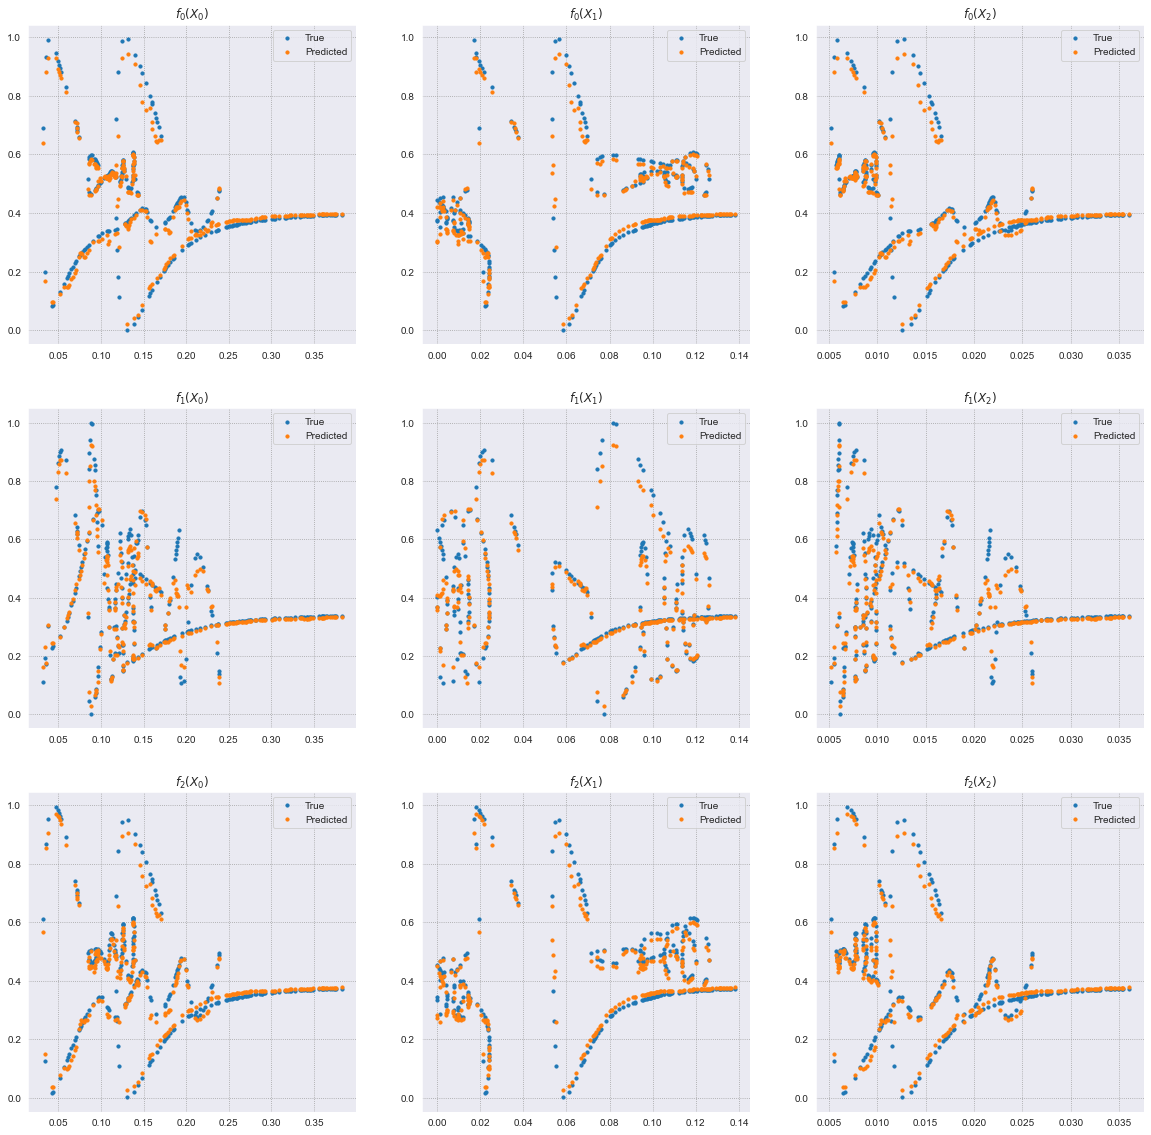

In [383]:
if len(train_data[0][1]) != 1:
    plot_matrix(
        X=[elem[:-3] for elem in val_X] if MODE == "movements" else val_X,
        K=CFG.K,
        Y_true=Y_true,
        Y_pred=Y_pred,

        figsize=(20, 20)
    )

---
# Модель для скоростей:

In [384]:
train_data_vel, val_data_vel, train_dataloader_vel, val_dataloader_vel, descaler_vel = recieve_loaders(
    batch_size=CFG.batch_size,

    # take_one_projection_for_data=0,
    path=path_vel,

    cut_size=None,

    # normalize_X=True,
    scale_y=True,

    # even_for_train=True
    )

In [385]:
model_vel = SingleNet(
    flattened_size=len(train_data[0][0]),

    output_size=len(train_data[0][1]),

    # activation=nn.Sigmoid(),
    # activation=nn.Tanh(),
    activation=nn.ReLU(),

).to(CFG.device)

optimizer_vel = optim.Adam(model_vel.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.0001)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler_vel = lr_scheduler.StepLR(optimizer_vel, step_size=5, gamma=0.95)

In [405]:
history_vel = train(
    train_loader=train_dataloader_vel, val_loader=val_dataloader_vel, model=model_vel, optimizer=optimizer_vel,
    
    scheduler=exp_scheduler_vel,
    scaler=None,
    
    # criterion=MultiOutputMSELoss(),     # on K=1 it's the same as nn.MSELoss
    criterion=nn.MSELoss(),
    # criterion = GaussianNLLLossWithReadyVar(),
    # criterion=MeanAbsolutePercentageError(),

    show_3D_quality=False if len(train_data[0][1]) == 1 else True,    # ПОКА ЧИСТО ТЕСТЮ НА ОДНОЙ ПРОЕКЦИИ И ТАМ РАЗМЕРНОСТИ НЕ СОВПАДАЮТ
    
    epochs=100,

    print_step=50,
    descaler=descaler_vel
)

epoch:   5%|▌         | 5/100 [00:00<00:04, 21.08it/s]


Epoch 001 train_loss: 0.003229 val_loss: 0.010200 train_mse: 0.000003 val_mse: 0.000010


epoch:  56%|█████▌    | 56/100 [00:02<00:01, 25.04it/s]


Epoch 051 train_loss: 0.001666 val_loss: 0.008332 train_mse: 0.000002 val_mse: 0.000008


epoch: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


MSE: 0.00754, mape: 0.1057 %, MSE_for_3D_after_pinv_A: 0.00037, mape_3d: 116.4964 %


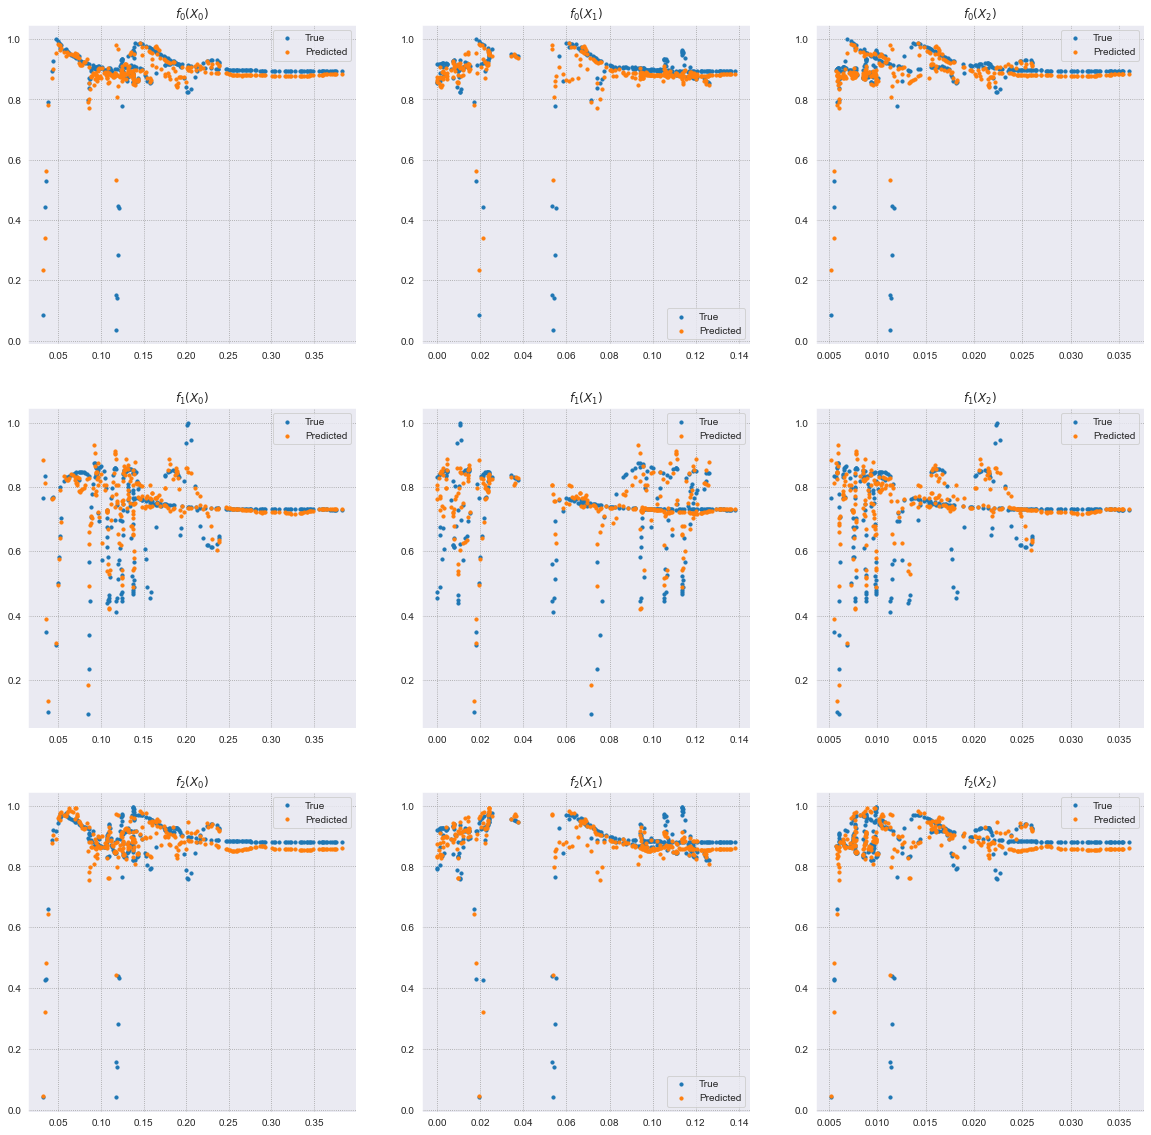

In [408]:
Y_pred_vel, Y_target_vel, Y_target_3D, Y_pred_3D = make_predictions_and_get_quality(
    model=model_vel, data=val_data_vel, same_axis=True,
    show_3D_quality=False if len(train_data[0][1]) == 1 else True, 

    descaler = descaler_vel
    )

Y_true_vel = Y_target_vel.squeeze().detach().numpy()
Y_pred_vel = Y_pred_vel.squeeze().detach().numpy()

plot_matrix(
    X=[elem[:-3] for elem in val_X] if MODE == "movements" else val_X,
    K=CFG.K,
    Y_true=Y_true_vel,
    Y_pred=Y_pred_vel,

    figsize=(20, 20),
)

In [ ]:
import dill

In [ ]:
model_file_path = f'./trained_models/network_{CFG.N}_movements_K{CFG.K}.pickle'
model_vel_file_path = f'./trained_models/network_{CFG.N}_velocities_K{CFG.K}.pickle'

descaler_path = f'./trained_models/descaler_{CFG.N}_velocities_K{CFG.K}.pickle'

In [ ]:
pickle_mov = open(model_file_path, 'wb')
dill.dump(model, pickle_mov)
pickle_mov.close()

In [ ]:
pickle_vel = open(model_vel_file_path, 'wb')
dill.dump(model_vel, pickle_vel)
pickle_vel.close()

In [ ]:
with open(f'./trained_models/network_{CFG.N}_movements_K{CFG.K}.pickle', 'rb') as handle:
    model = dill.load(handle)

---
---
---

Другой вариант:

Обучиться предсказывать элементарное перемещение по радиус вектору + вектору скорости (пока без скоростей)

Без скоростей - предсказание перемещения эквивалентно предсказанию силы:

$$
r(t+\Delta t) = r(t) v(t)\Delta t + \dfrac{1}{2}a(t)(\Delta t)^2
$$

$$
r(t+\Delta t) - r(t) = v(t)\Delta t + \dfrac{1}{2}a(t)(\Delta t)^2
$$

Ща два важных момента:
- эксопнента в формуле 
- пока матрица остается диагональной

- ITEM: TIMESTEP - это шаг интегратора; 

Что ща: надо обучить предсказывать элементарное перемещение - если пока не сработает на только координатах, то это норм, так как нужны еще скорости, но вообще скорости, координаты и силы - все это связано весьма явно: ускорение по предположению явная функция только координат, а остальнлое интегрированием

Короче: Имея координаты мы же можем предсказать силу, а из формулы верле это дает нам, что мы можем элементарное смещение за $\Delta$, зная скорости и координаты предсказать, поэтому текущая задача: на координатах обучиться предсказывать уже не силу, а элементарное смещение - так как наша задача интегрировать уравнения движения, еще раз скажу, что без скорости оно может не получиться и получение элементарного смещения вообще говоря может быть надо делать 2 моделями: одна по 

- Добавить в выпрямленную матрицу X в конец 3 числа: vx, vy, vz
- Для двух частиц "невращающихся" на матрице X из векторов V - которые по функции Леннарда Джонса на K = 3 на диагональной матрцие посчитаны

**Обучаем на перемещения**